In [1]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, cosine
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [2]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')

In [3]:
df = ds.to_dataframe()
df_orig = df.copy()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

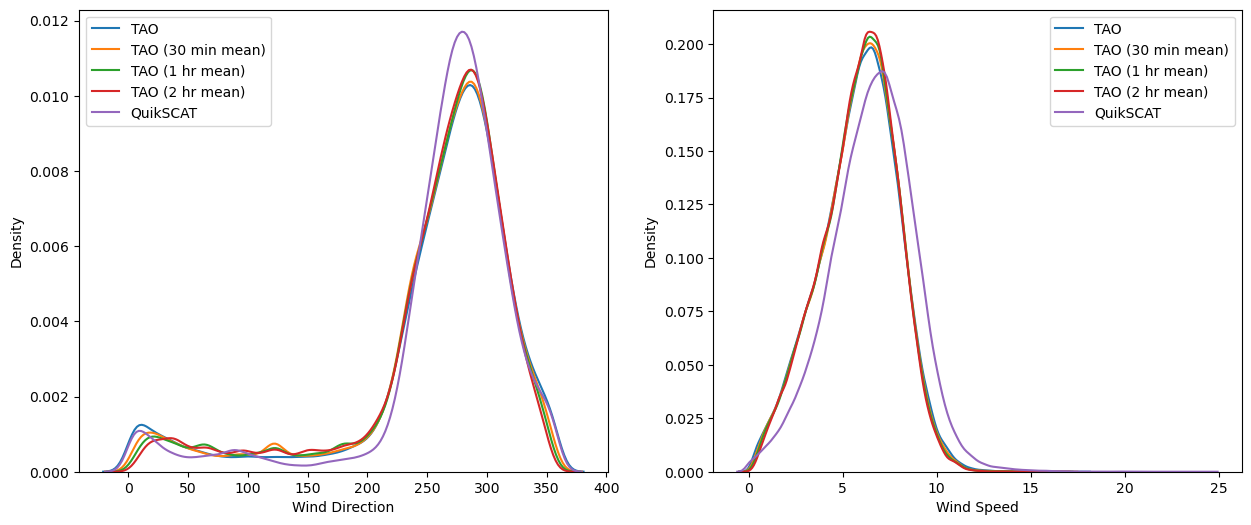

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['Wind Direction (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Direction (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Direction')
ax.legend()

ax = axes[1]
sns.kdeplot(df['Wind Speed (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WSPD 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WSPD 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WSPD 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Speed (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Speed')
ax.legend()

In [5]:
df = ds.to_dataframe()

df['Speed Difference (QuikSCAT - TAO)'] = df['Wind Speed (QuikSCAT)'] - df['Wind Speed (TAO)']

df['Wind Direction (TAO)'] = (-(df['Wind Direction (TAO)'] - 90.0) + 360)%360
df['Wind Direction (QuikSCAT)'] = (-(df['Wind Direction (QuikSCAT)'] - 90.0) + 360)%360
df['mean WDIR 30min'] = (-(df['mean WDIR 30min'] - 90.0) + 360)%360
df['mean WDIR 60min'] = (-(df['mean WDIR 60min'] - 90.0) + 360)%360
df['mean WDIR 120min'] = (-(df['mean WDIR 120min'] - 90.0) + 360)%360

df['Direction Difference (QuikSCAT - TAO)'] = ((df['Wind Direction (QuikSCAT)'] - df['Wind Direction (TAO)'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 30 min mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 30min']
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 30min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 30 min mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 30 min mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 1 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 60min']
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 60min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 1 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 1 hr mean)'] = dirDiff

df['Speed Difference (QuikSCAT - TAO 2 hr mean)'] = df['Wind Speed (QuikSCAT)'] - df['mean WSPD 120min']
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = ((df['Wind Direction (QuikSCAT)'] - df['mean WDIR 120min'])+360)%360
dirDiff = np.array(df['Direction Difference (QuikSCAT - TAO 2 hr mean)'])
dirDiff[dirDiff > 180] -= 360
df['Direction Difference (QuikSCAT - TAO 2 hr mean)'] = dirDiff


df['Zonal Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['Meridional Neutral Wind Speed at 10m (TAO)'] = df['Neutral Wind Speed at 10m (TAO)']*np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.cos(np.deg2rad(df['Wind Direction (QuikSCAT)']))
df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] = df['Wind Speed (QuikSCAT)']*np.sin(np.deg2rad(df['Wind Direction (QuikSCAT)']))

df['Zonal Wind Speed Difference (QuikSCAT - TAO)'] = df['Zonal Neutral Wind Speed at 10m (QuikSCAT)'] - df['Zonal Neutral Wind Speed at 10m (TAO)']
df['Meridional Wind Speed Difference (QuikSCAT - TAO)'] = df['Meridional Neutral Wind Speed at 10m (QuikSCAT)'] - df['Meridional Neutral Wind Speed at 10m (TAO)']

df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

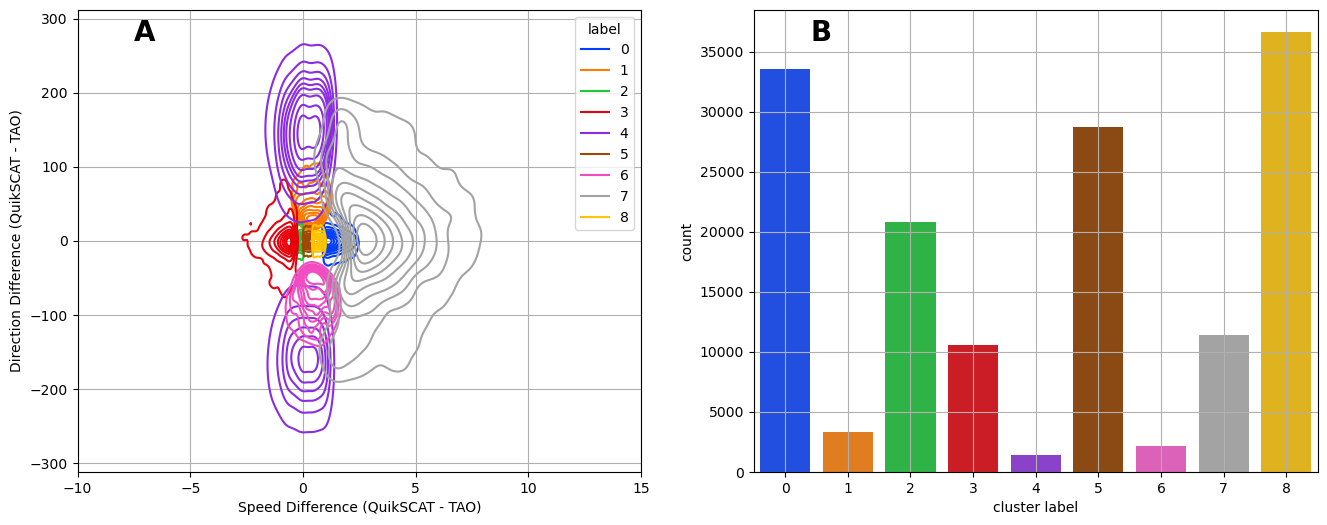

In [6]:
def kmeans_cosine(X, n_clusters, max_iter=300, tol=1e-4):
    # Normalize the data to make it suitable for cosine similarity
    X_normalized = normalize(X)

    # Randomly initialize the centroids
    centroids = X_normalized[np.random.choice(X_normalized.shape[0], n_clusters, replace=False)]
    #centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]

    for i in range(max_iter):
        # Compute cosine distances between points and centroids
        distances = cdist(X_normalized, centroids, metric='cosine')
        #distances = cdist(X, centroids, metric='cosine')

        # Assign clusters based on the closest centroids
        clusters = np.argmin(distances, axis=1)

        # Calculate new centroids
        new_centroids = np.array([X_normalized[clusters == j].mean(axis=0) for j in range(n_clusters)])
        #new_centroids = np.array([X[clusters == j].mean(axis=0) for j in range(n_clusters)])

        # # Normalize new centroids
        new_centroids = normalize(new_centroids)

        # Check for convergence
        if np.allclose(centroids, new_centroids, atol=tol):
            break

        centroids = new_centroids

    return clusters, centroids

#data

selectX = ['Speed Difference (QuikSCAT - TAO)',
           'cos(Direction Difference (QuikSCAT - TAO))',
           'sin(Direction Difference (QuikSCAT - TAO))']

data = df[selectX].to_numpy()

# Apply K-means with cosine similarity
n_clusters = 9
clusters, centroids = kmeans_cosine(data, n_clusters)

df['label'] = clusters

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


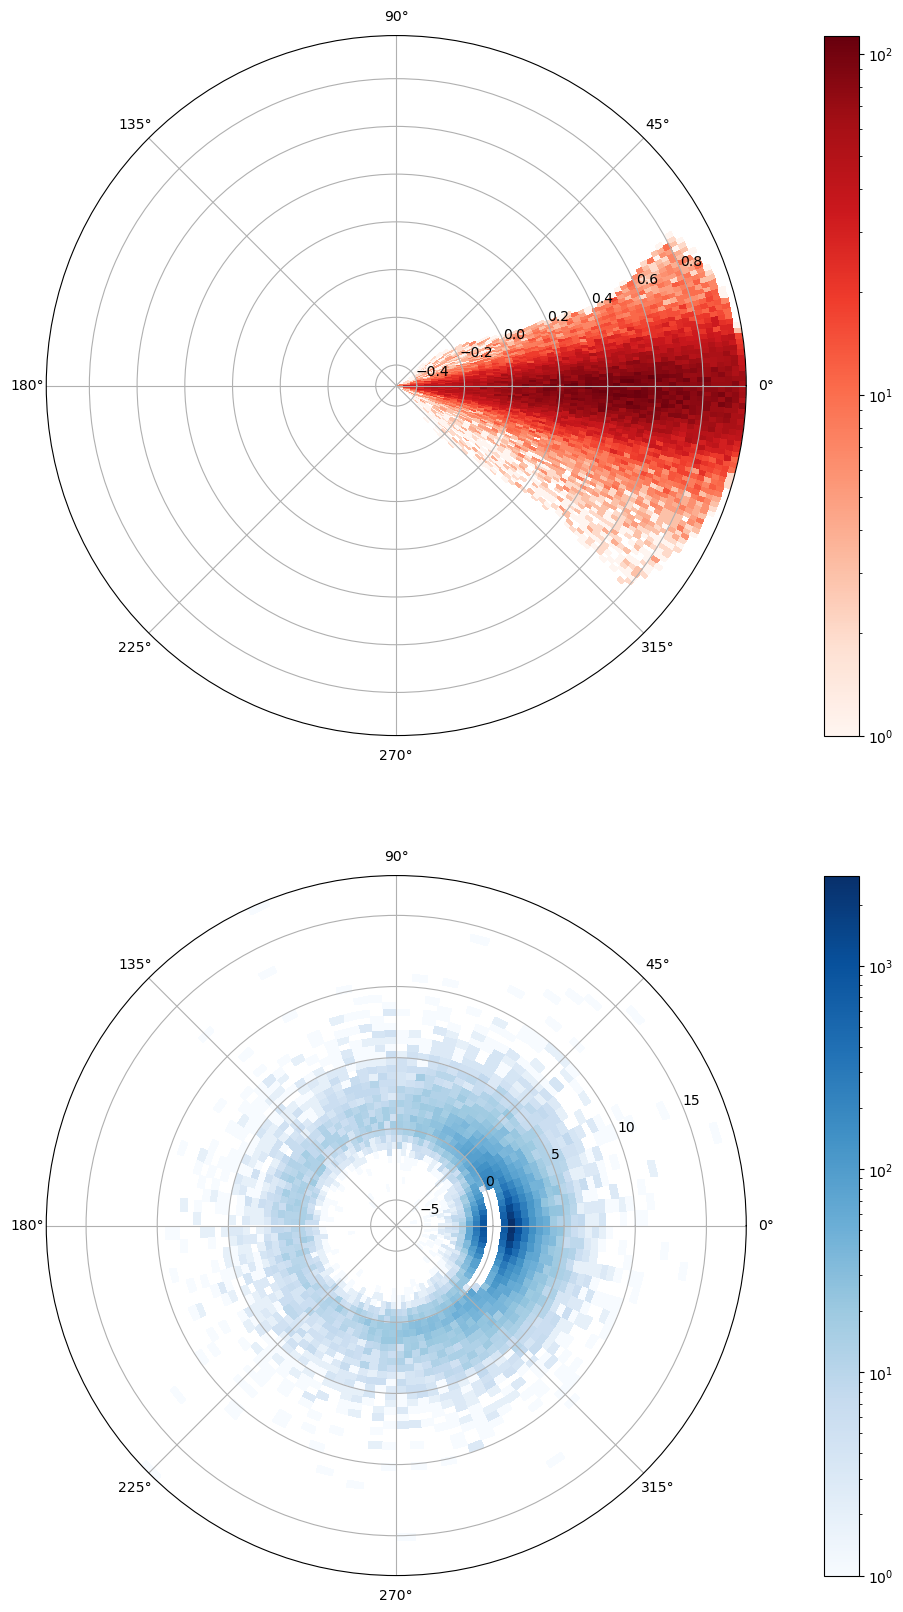

In [10]:
fig, axes = plt.subplots(nrows=2 , ncols=1, figsize=(20,20))
ax = axes[0]
ax.remove()  # Remove the existing second subplot
ax = fig.add_subplot(211, projection='polar')
subDF = df.loc[df['label'].isin([5,2,8])]
#sns.histplot(subDF, y='Wind Speed (QuikSCAT)', x='Wind Direction (QuikSCAT)', cbar=True, ax= ax)

theta = subDF['Direction Difference (QuikSCAT - TAO)']
r = subDF['Speed Difference (QuikSCAT - TAO)']
# Create a 2D histogram
hist, r_edges, theta_edges = np.histogram2d(r, theta, bins=[50,100])

# Convert bin edges to bin centers
r_centers = (r_edges[:-1] + r_edges[1:]) / 2
theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2

# Create a meshgrid for r and theta
R, Theta = np.meshgrid(r_centers, np.deg2rad(theta_centers))

# Plot the data using pcolormesh
c = ax.pcolormesh(Theta, R, hist.T, shading='auto', cmap='Reds', norm=colors.LogNorm() )#, levels=10)
plt.colorbar(c, ax= ax)

#######################################################################################
ax = axes[1]
ax.remove()  # Remove the existing second subplot
ax = fig.add_subplot(212, projection='polar')
subDF = df.loc[df['label'].isin([1,3,4,6,7, 0])]
theta = subDF['Direction Difference (QuikSCAT - TAO)']
r = subDF['Speed Difference (QuikSCAT - TAO)']
# Create a 2D histogram
hist, r_edges, theta_edges = np.histogram2d(r, theta, bins=[50,100])

# Convert bin edges to bin centers
r_centers = (r_edges[:-1] + r_edges[1:]) / 2
theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2

# Create a meshgrid for r and theta
R, Theta = np.meshgrid(r_centers, np.deg2rad(theta_centers))

# Plot the data using pcolormesh
c2 = ax.pcolormesh(Theta, R, hist.T, shading='auto', cmap='Blues', norm=colors.LogNorm() )
plt.colorbar(c2, ax = ax)
#######################################################################################



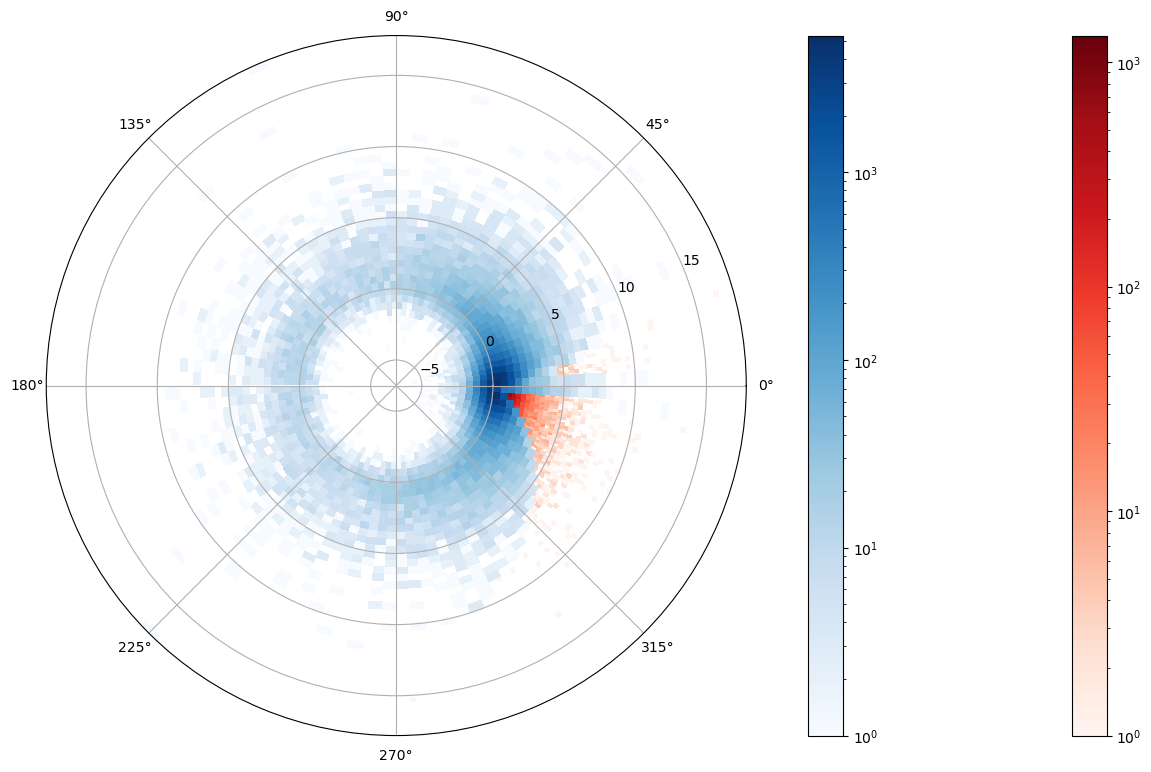

In [8]:
fig, ax = plt.subplots(nrows=1 , ncols=1, figsize=(20,20))
#ax = axes[0]
ax.remove()  # Remove the existing second subplot
ax = fig.add_subplot(211, projection='polar')
subDF = df.loc[df['label'].isin([0, 1, 5])]
#sns.histplot(subDF, y='Wind Speed (QuikSCAT)', x='Wind Direction (QuikSCAT)', cbar=True, ax= ax)

theta = subDF['Direction Difference (QuikSCAT - TAO)']
r = subDF['Speed Difference (QuikSCAT - TAO)']
# Create a 2D histogram
hist, r_edges, theta_edges = np.histogram2d(r, theta, bins=[50,100])

# Convert bin edges to bin centers
r_centers = (r_edges[:-1] + r_edges[1:]) / 2
theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2

# Create a meshgrid for r and theta
R, Theta = np.meshgrid(r_centers, np.deg2rad(theta_centers))

# Plot the data using pcolormesh
c = ax.pcolormesh(Theta, R, hist.T, shading='auto', cmap='Reds', norm=colors.LogNorm() )#, levels=10)
plt.colorbar(c, ax= ax)

#######################################################################################
# ax = axes[1]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(212, projection='polar')
subDF = df.loc[df['label'].isin([2,3,4,6,7,8])]
theta = subDF['Direction Difference (QuikSCAT - TAO)']
r = subDF['Speed Difference (QuikSCAT - TAO)']
# Create a 2D histogram
hist, r_edges, theta_edges = np.histogram2d(r, theta, bins=[50,100])

# Convert bin edges to bin centers
r_centers = (r_edges[:-1] + r_edges[1:]) / 2
theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2

# Create a meshgrid for r and theta
R, Theta = np.meshgrid(r_centers, np.deg2rad(theta_centers))

# Plot the data using pcolormesh
c2 = ax.pcolormesh(Theta, R, hist.T, shading='auto', cmap='Blues', norm=colors.LogNorm() )
plt.colorbar(c2, ax = ax)
#######################################################################################

